In [1]:
import os
import sys

project_root = os.getcwd()
while "src" not in os.listdir(project_root):
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

In [6]:
import torch
from torch.utils.data import DataLoader
from src.pipelines import train_pipeline, inference_pipeline
from src.models import SimpleUNet, SCUNet, DeepSampler
from src.utils.data import MUSDB18Dataset
from src.utils.training import MultiSourceL1Loss
import numpy as np
import matplotlib.pyplot as plt
import librosa

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

experiments_path = os.path.join(project_root, "experiments")
data_root = os.path.join(project_root, "data")
checkpoint_path = os.path.join(experiments_path, "checkpoints")
scunet_path = os.path.join(checkpoint_path, "scunet.pth")
results_path = os.path.join(experiments_path, "results")
musdb_path = os.path.join(project_root, "data", "musdb18hq", "train")
musdb_files = os.listdir(musdb_path)
musdb_files.sort()

Using device: cuda


In [17]:
deep_sampler = DeepSampler()
x = torch.randn(1, 1, 1025, 173)  # (batch, channels, height, width)
output = deep_sampler(x)  # Salida: (1, 4, 1025, 173)
output.shape

torch.Size([1, 4, 1025, 173])

In [3]:
simple_unet = SimpleUNet(base_channels=32, depth=3)
x = torch.randn(1, 1, 1025, 173)  # (batch, channels, height, width)
output = simple_unet(x)  # Salida: (1, 4, 1025, 173)
output.shape

torch.Size([1, 4, 1025, 173])

In [ ]:
scunet = SCUNet()
x = torch.randn(1, 1, 1025, 173)  # (batch, channels, height, width)
output = scunet(x)  # Salida: (1, 4, 1025, 173)
output.shape

In [7]:
train_dataset = MUSDB18Dataset(os.path.join(data_root, "processed", "train"))
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True
)
mixture, _ = train_dataset.__getitem__(0)
print("Sample input shape:", mixture.shape)

Sample input shape: torch.Size([1, 1025, 173])


In [8]:
simple_unet.to(device)

criterion = MultiSourceL1Loss(weights=[0.297, 0.262, 0.232, 0.209])
optimizer = torch.optim.Adam(simple_unet.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

total_epochs = 40
phase1_epochs = 20

In [18]:
deep_sampler.to(device)

criterion = MultiSourceL1Loss(weights=[0.297, 0.262, 0.232, 0.209])
optimizer = torch.optim.Adam(deep_sampler.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

total_epochs = 40
phase1_epochs = 20

In [9]:
trained_model = train_pipeline(
    model=simple_unet,
    dataloader=train_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    total_epochs=total_epochs,
    phase1_epochs=phase1_epochs,
)

Training Progress:   2%|▎         | 1/40 [00:08<05:47,  8.92s/epoch]

Epoch 1 completed - Avg Loss: 0.0870 - LR: 1.0e-03


Training Progress:   5%|▌         | 2/40 [00:18<06:04,  9.59s/epoch]

Epoch 2 completed - Avg Loss: 0.0765 - LR: 1.0e-03


Training Progress:   8%|▊         | 3/40 [00:28<05:46,  9.37s/epoch]

Epoch 3 completed - Avg Loss: 0.0765 - LR: 1.0e-03


Training Progress:  10%|█         | 4/40 [00:36<05:20,  8.89s/epoch]

Epoch 4 completed - Avg Loss: 0.0757 - LR: 1.0e-03


Training Progress:  12%|█▎        | 5/40 [00:45<05:09,  8.84s/epoch]

Epoch 5 completed - Avg Loss: 0.0738 - LR: 1.0e-03


Training Progress:  15%|█▌        | 6/40 [00:53<04:53,  8.63s/epoch]

Epoch 6 completed - Avg Loss: 0.0737 - LR: 1.0e-03


Training Progress:  18%|█▊        | 7/40 [01:01<04:41,  8.54s/epoch]

Epoch 7 completed - Avg Loss: 0.0725 - LR: 1.0e-03


Training Progress:  20%|██        | 8/40 [01:10<04:34,  8.57s/epoch]

Epoch 8 completed - Avg Loss: 0.0713 - LR: 1.0e-03


Training Progress:  22%|██▎       | 9/40 [01:18<04:21,  8.44s/epoch]

Epoch 9 completed - Avg Loss: 0.0727 - LR: 1.0e-03


Training Progress:  25%|██▌       | 10/40 [01:26<04:12,  8.43s/epoch]

Epoch 10 completed - Avg Loss: 0.0701 - LR: 1.0e-03


Training Progress:  28%|██▊       | 11/40 [01:35<04:05,  8.46s/epoch]

Epoch 11 completed - Avg Loss: 0.0708 - LR: 1.0e-03


Training Progress:  30%|███       | 12/40 [01:44<04:00,  8.58s/epoch]

Epoch 12 completed - Avg Loss: 0.0702 - LR: 1.0e-03


Training Progress:  32%|███▎      | 13/40 [01:52<03:47,  8.41s/epoch]

Epoch 13 completed - Avg Loss: 0.0703 - LR: 1.0e-03


Training Progress:  35%|███▌      | 14/40 [02:00<03:37,  8.38s/epoch]

Epoch 14 completed - Avg Loss: 0.0689 - LR: 1.0e-03


Training Progress:  38%|███▊      | 15/40 [02:08<03:27,  8.30s/epoch]

Epoch 15 completed - Avg Loss: 0.0727 - LR: 1.0e-03


Training Progress:  40%|████      | 16/40 [02:17<03:21,  8.41s/epoch]

Epoch 16 completed - Avg Loss: 0.0716 - LR: 1.0e-03


Training Progress:  42%|████▎     | 17/40 [02:26<03:16,  8.56s/epoch]

Epoch 17 completed - Avg Loss: 0.0702 - LR: 1.0e-03


Training Progress:  45%|████▌     | 18/40 [02:34<03:09,  8.62s/epoch]

Epoch 18 completed - Avg Loss: 0.0696 - LR: 1.0e-03


Training Progress:  48%|████▊     | 19/40 [02:43<03:00,  8.57s/epoch]

Epoch 19 completed - Avg Loss: 0.0685 - LR: 1.0e-03


Training Progress:  50%|█████     | 20/40 [02:51<02:51,  8.58s/epoch]

Epoch 20 completed - Avg Loss: 0.0688 - LR: 1.0e-04

Starting second training phase (lr=1e-4)


Training Progress:  52%|█████▎    | 21/40 [03:00<02:40,  8.43s/epoch]

Epoch 21 completed - Avg Loss: 0.0686 - LR: 1.0e-04


Training Progress:  55%|█████▌    | 22/40 [03:09<02:34,  8.60s/epoch]

Epoch 22 completed - Avg Loss: 0.0681 - LR: 1.0e-04


Training Progress:  57%|█████▊    | 23/40 [03:17<02:24,  8.52s/epoch]

Epoch 23 completed - Avg Loss: 0.0704 - LR: 1.0e-04


Training Progress:  60%|██████    | 24/40 [03:25<02:14,  8.40s/epoch]

Epoch 24 completed - Avg Loss: 0.0667 - LR: 1.0e-04


Training Progress:  62%|██████▎   | 25/40 [03:34<02:06,  8.45s/epoch]

Epoch 25 completed - Avg Loss: 0.0684 - LR: 1.0e-04


Training Progress:  65%|██████▌   | 26/40 [03:42<01:59,  8.52s/epoch]

Epoch 26 completed - Avg Loss: 0.0694 - LR: 1.0e-04


Training Progress:  68%|██████▊   | 27/40 [03:50<01:49,  8.41s/epoch]

Epoch 27 completed - Avg Loss: 0.0685 - LR: 1.0e-04


Training Progress:  70%|███████   | 28/40 [03:59<01:42,  8.56s/epoch]

Epoch 28 completed - Avg Loss: 0.0659 - LR: 1.0e-04


Training Progress:  72%|███████▎  | 29/40 [04:08<01:33,  8.47s/epoch]

Epoch 29 completed - Avg Loss: 0.0668 - LR: 1.0e-04


Training Progress:  75%|███████▌  | 30/40 [04:16<01:25,  8.53s/epoch]

Epoch 30 completed - Avg Loss: 0.0671 - LR: 1.0e-04


Training Progress:  78%|███████▊  | 31/40 [04:24<01:15,  8.43s/epoch]

Epoch 31 completed - Avg Loss: 0.0657 - LR: 1.0e-04


Training Progress:  80%|████████  | 32/40 [04:33<01:07,  8.42s/epoch]

Epoch 32 completed - Avg Loss: 0.0670 - LR: 1.0e-04


Training Progress:  82%|████████▎ | 33/40 [04:41<00:58,  8.35s/epoch]

Epoch 33 completed - Avg Loss: 0.0673 - LR: 1.0e-04


Training Progress:  85%|████████▌ | 34/40 [04:49<00:50,  8.35s/epoch]

Epoch 34 completed - Avg Loss: 0.0659 - LR: 1.0e-04


Training Progress:  88%|████████▊ | 35/40 [04:58<00:41,  8.30s/epoch]

Epoch 35 completed - Avg Loss: 0.0666 - LR: 1.0e-04


Training Progress:  90%|█████████ | 36/40 [05:07<00:34,  8.73s/epoch]

Epoch 36 completed - Avg Loss: 0.0661 - LR: 1.0e-04


Training Progress:  92%|█████████▎| 37/40 [05:16<00:25,  8.63s/epoch]

Epoch 37 completed - Avg Loss: 0.0652 - LR: 1.0e-04


Training Progress:  95%|█████████▌| 38/40 [05:24<00:17,  8.56s/epoch]

Epoch 38 completed - Avg Loss: 0.0655 - LR: 1.0e-04


Training Progress:  98%|█████████▊| 39/40 [05:33<00:08,  8.58s/epoch]

Epoch 39 completed - Avg Loss: 0.0655 - LR: 1.0e-04


Training Progress: 100%|██████████| 40/40 [05:41<00:00,  8.54s/epoch]

Epoch 40 completed - Avg Loss: 0.0652 - LR: 1.0e-05


In [19]:
trained_model = train_pipeline(
    model=deep_sampler,
    dataloader=train_loader,
    device=device,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    total_epochs=total_epochs,
    phase1_epochs=phase1_epochs,
)

Training Progress:   2%|▎         | 1/40 [00:09<05:53,  9.06s/epoch]

Epoch 1 completed - Avg Loss: 0.0904 - LR: 1.0e-03


Training Progress:   5%|▌         | 2/40 [00:18<05:44,  9.07s/epoch]

Epoch 2 completed - Avg Loss: 0.0801 - LR: 1.0e-03


Training Progress:   8%|▊         | 3/40 [00:27<05:33,  9.02s/epoch]

Epoch 3 completed - Avg Loss: 0.0779 - LR: 1.0e-03


Training Progress:  10%|█         | 4/40 [00:36<05:31,  9.22s/epoch]

Epoch 4 completed - Avg Loss: 0.0769 - LR: 1.0e-03


Training Progress:  12%|█▎        | 5/40 [00:46<05:29,  9.41s/epoch]

Epoch 5 completed - Avg Loss: 0.0766 - LR: 1.0e-03


Training Progress:  15%|█▌        | 6/40 [00:56<05:23,  9.53s/epoch]

Epoch 6 completed - Avg Loss: 0.0755 - LR: 1.0e-03


Training Progress:  18%|█▊        | 7/40 [01:05<05:16,  9.58s/epoch]

Epoch 7 completed - Avg Loss: 0.0761 - LR: 1.0e-03


Training Progress:  20%|██        | 8/40 [01:14<05:02,  9.44s/epoch]

Epoch 8 completed - Avg Loss: 0.0755 - LR: 1.0e-03


Training Progress:  22%|██▎       | 9/40 [01:24<04:49,  9.34s/epoch]

Epoch 9 completed - Avg Loss: 0.0753 - LR: 1.0e-03


Training Progress:  25%|██▌       | 10/40 [01:33<04:41,  9.37s/epoch]

Epoch 10 completed - Avg Loss: 0.0733 - LR: 1.0e-03


Training Progress:  28%|██▊       | 11/40 [01:42<04:26,  9.18s/epoch]

Epoch 11 completed - Avg Loss: 0.0723 - LR: 1.0e-03


Training Progress:  30%|███       | 12/40 [01:52<04:25,  9.47s/epoch]

Epoch 12 completed - Avg Loss: 0.0750 - LR: 1.0e-03


Training Progress:  32%|███▎      | 13/40 [02:01<04:13,  9.39s/epoch]

Epoch 13 completed - Avg Loss: 0.0738 - LR: 1.0e-03


Training Progress:  35%|███▌      | 14/40 [02:11<04:07,  9.53s/epoch]

Epoch 14 completed - Avg Loss: 0.0732 - LR: 1.0e-03


Training Progress:  38%|███▊      | 15/40 [02:20<03:53,  9.35s/epoch]

Epoch 15 completed - Avg Loss: 0.0739 - LR: 1.0e-03


Training Progress:  40%|████      | 16/40 [02:29<03:45,  9.39s/epoch]

Epoch 16 completed - Avg Loss: 0.0724 - LR: 1.0e-03


Training Progress:  42%|████▎     | 17/40 [02:39<03:40,  9.58s/epoch]

Epoch 17 completed - Avg Loss: 0.0711 - LR: 1.0e-03


Training Progress:  45%|████▌     | 18/40 [02:48<03:27,  9.45s/epoch]

Epoch 18 completed - Avg Loss: 0.0707 - LR: 1.0e-03


Training Progress:  48%|████▊     | 19/40 [02:58<03:18,  9.46s/epoch]

Epoch 19 completed - Avg Loss: 0.0707 - LR: 1.0e-03


Training Progress:  50%|█████     | 20/40 [03:08<03:10,  9.53s/epoch]

Epoch 20 completed - Avg Loss: 0.0714 - LR: 1.0e-04

Starting second training phase (lr=1e-4)


Training Progress:  52%|█████▎    | 21/40 [03:17<03:01,  9.57s/epoch]

Epoch 21 completed - Avg Loss: 0.0697 - LR: 1.0e-04


Training Progress:  55%|█████▌    | 22/40 [03:26<02:46,  9.24s/epoch]

Epoch 22 completed - Avg Loss: 0.0694 - LR: 1.0e-04


Training Progress:  57%|█████▊    | 23/40 [03:34<02:32,  8.98s/epoch]

Epoch 23 completed - Avg Loss: 0.0698 - LR: 1.0e-04


Training Progress:  60%|██████    | 24/40 [03:44<02:25,  9.10s/epoch]

Epoch 24 completed - Avg Loss: 0.0681 - LR: 1.0e-04


Training Progress:  62%|██████▎   | 25/40 [03:53<02:19,  9.28s/epoch]

Epoch 25 completed - Avg Loss: 0.0695 - LR: 1.0e-04


Training Progress:  65%|██████▌   | 26/40 [04:03<02:10,  9.33s/epoch]

Epoch 26 completed - Avg Loss: 0.0702 - LR: 1.0e-04


Training Progress:  68%|██████▊   | 27/40 [04:13<02:04,  9.60s/epoch]

Epoch 27 completed - Avg Loss: 0.0676 - LR: 1.0e-04


Training Progress:  70%|███████   | 28/40 [04:22<01:53,  9.44s/epoch]

Epoch 28 completed - Avg Loss: 0.0699 - LR: 1.0e-04


Training Progress:  72%|███████▎  | 29/40 [04:32<01:45,  9.62s/epoch]

Epoch 29 completed - Avg Loss: 0.0684 - LR: 1.0e-04


Training Progress:  75%|███████▌  | 30/40 [04:41<01:35,  9.55s/epoch]

Epoch 30 completed - Avg Loss: 0.0675 - LR: 1.0e-04


Training Progress:  78%|███████▊  | 31/40 [04:51<01:25,  9.45s/epoch]

Epoch 31 completed - Avg Loss: 0.0694 - LR: 1.0e-04


Training Progress:  80%|████████  | 32/40 [05:00<01:15,  9.48s/epoch]

Epoch 32 completed - Avg Loss: 0.0671 - LR: 1.0e-04


Training Progress:  82%|████████▎ | 33/40 [05:09<01:04,  9.22s/epoch]

Epoch 33 completed - Avg Loss: 0.0671 - LR: 1.0e-04


Training Progress:  85%|████████▌ | 34/40 [05:18<00:55,  9.32s/epoch]

Epoch 34 completed - Avg Loss: 0.0676 - LR: 1.0e-04


Training Progress:  88%|████████▊ | 35/40 [05:28<00:47,  9.43s/epoch]

Epoch 35 completed - Avg Loss: 0.0677 - LR: 1.0e-04


Training Progress:  90%|█████████ | 36/40 [05:38<00:37,  9.45s/epoch]

Epoch 36 completed - Avg Loss: 0.0679 - LR: 1.0e-04


Training Progress:  92%|█████████▎| 37/40 [05:47<00:28,  9.41s/epoch]

Epoch 37 completed - Avg Loss: 0.0664 - LR: 1.0e-04


Training Progress:  95%|█████████▌| 38/40 [05:56<00:18,  9.40s/epoch]

Epoch 38 completed - Avg Loss: 0.0665 - LR: 1.0e-04


Training Progress:  98%|█████████▊| 39/40 [06:06<00:09,  9.61s/epoch]

Epoch 39 completed - Avg Loss: 0.0666 - LR: 1.0e-04


Training Progress: 100%|██████████| 40/40 [06:16<00:00,  9.40s/epoch]

Epoch 40 completed - Avg Loss: 0.0662 - LR: 1.0e-05


In [20]:
seconds = 10
random_sample = np.random.choice(musdb_files)
sample_path = os.path.join(musdb_path, random_sample)

In [21]:
mixture_path = os.path.join(sample_path, "mixture.wav")
vocals_path = os.path.join(sample_path, "vocals.wav")
bass_path = os.path.join(sample_path, "bass.wav")
drums_path = os.path.join(sample_path, "drums.wav")
other_path = os.path.join(sample_path, "other.wav")


mixture, sr = librosa.load(mixture_path, sr=None)
vocals, _ = librosa.load(vocals_path, sr=None)
bass, _ = librosa.load(bass_path, sr=None)
drums, _ = librosa.load(drums_path, sr=None)
other, _ = librosa.load(other_path, sr=None)


mixture = mixture[: int(seconds * sr)]
vocals = vocals[: int(seconds * sr)]
bass = bass[: int(seconds * sr)]
drums = drums[: int(seconds * sr)]
other = other[: int(seconds * sr)]

mixture_stft = librosa.stft(mixture, n_fft=2048, hop_length=512)
vocals_stft = librosa.stft(vocals, n_fft=2048, hop_length=512)
bass_stft = librosa.stft(bass, n_fft=2048, hop_length=512)
drums_stft = librosa.stft(drums, n_fft=2048, hop_length=512)
other_stft = librosa.stft(other, n_fft=2048, hop_length=512)

In [23]:
inference_pipeline(
    model=trained_model,
    mixture_path=mixture_path,
    output_path=os.path.join(results_path, f"deep_sampler"),
    device=device,
)

Processing chunks: 100%|██████████| 90/90 [00:02<00:00, 32.57it/s]


In [24]:
res_vocals_path = os.path.join(results_path, "deep_sampler", "vocals.wav")
res_bass_path = os.path.join(results_path, "deep_sampler", "bass.wav")
res_drums_path = os.path.join(results_path, "deep_sampler", "drums.wav")
res_other_path = os.path.join(results_path, "deep_sampler", "other.wav")

res_vocals, sr = librosa.load(res_vocals_path, sr=None)
res_bass, _ = librosa.load(res_bass_path, sr=None)
res_drums, _ = librosa.load(res_drums_path, sr=None)
res_other, _ = librosa.load(res_other_path, sr=None)

res_vocals = res_vocals[: int(seconds * sr)]
res_bass = res_bass[: int(seconds * sr)]
res_drums = res_drums[: int(seconds * sr)]
res_other = res_other[: int(seconds * sr)]

res_vocals_stft = librosa.stft(res_vocals, n_fft=2048, hop_length=512)
res_bass_stft = librosa.stft(res_bass, n_fft=2048, hop_length=512)
res_drums_stft = librosa.stft(res_drums, n_fft=2048, hop_length=512)
res_other_stft = librosa.stft(res_other, n_fft=2048, hop_length=512)

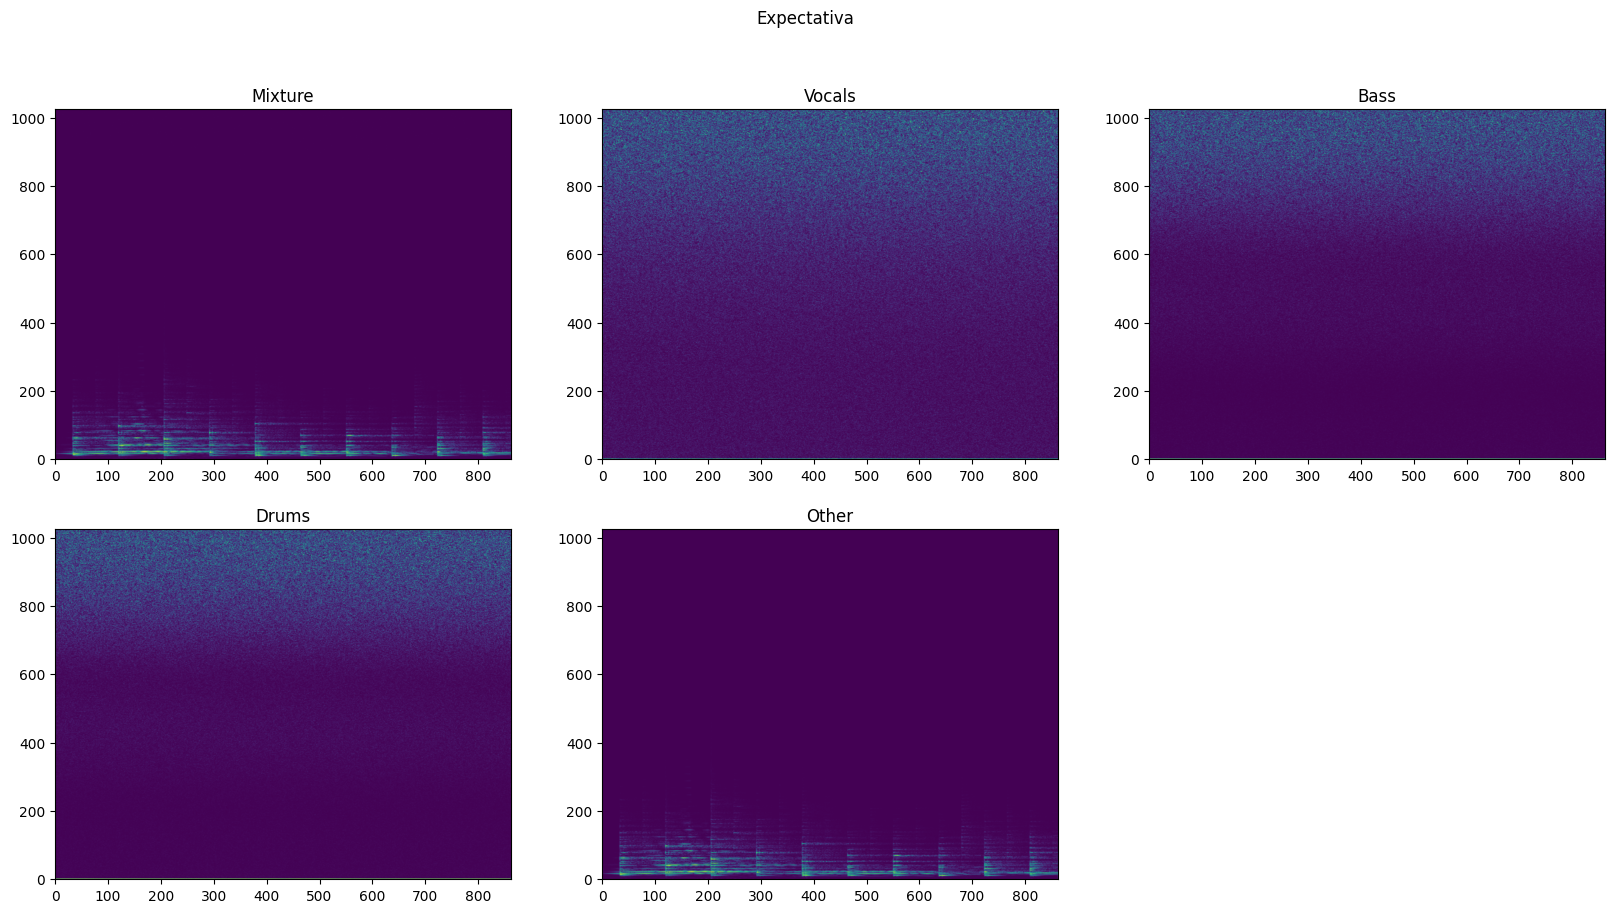

In [25]:
plt.figure(figsize=(20, 10))
plt.suptitle("Expectativa")
plt.subplot(2, 3, 1)
plt.title("Mixture")
plt.imshow(np.log1p(np.abs(mixture_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 2)
plt.title("Vocals")
plt.imshow(np.log1p(np.abs(vocals_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 3)
plt.title("Bass")
plt.imshow(np.log1p(np.abs(bass_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 4)
plt.title("Drums")
plt.imshow(np.log1p(np.abs(drums_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 5)
plt.title("Other")
plt.imshow(np.log1p(np.abs(other_stft)), aspect="auto", origin="lower")

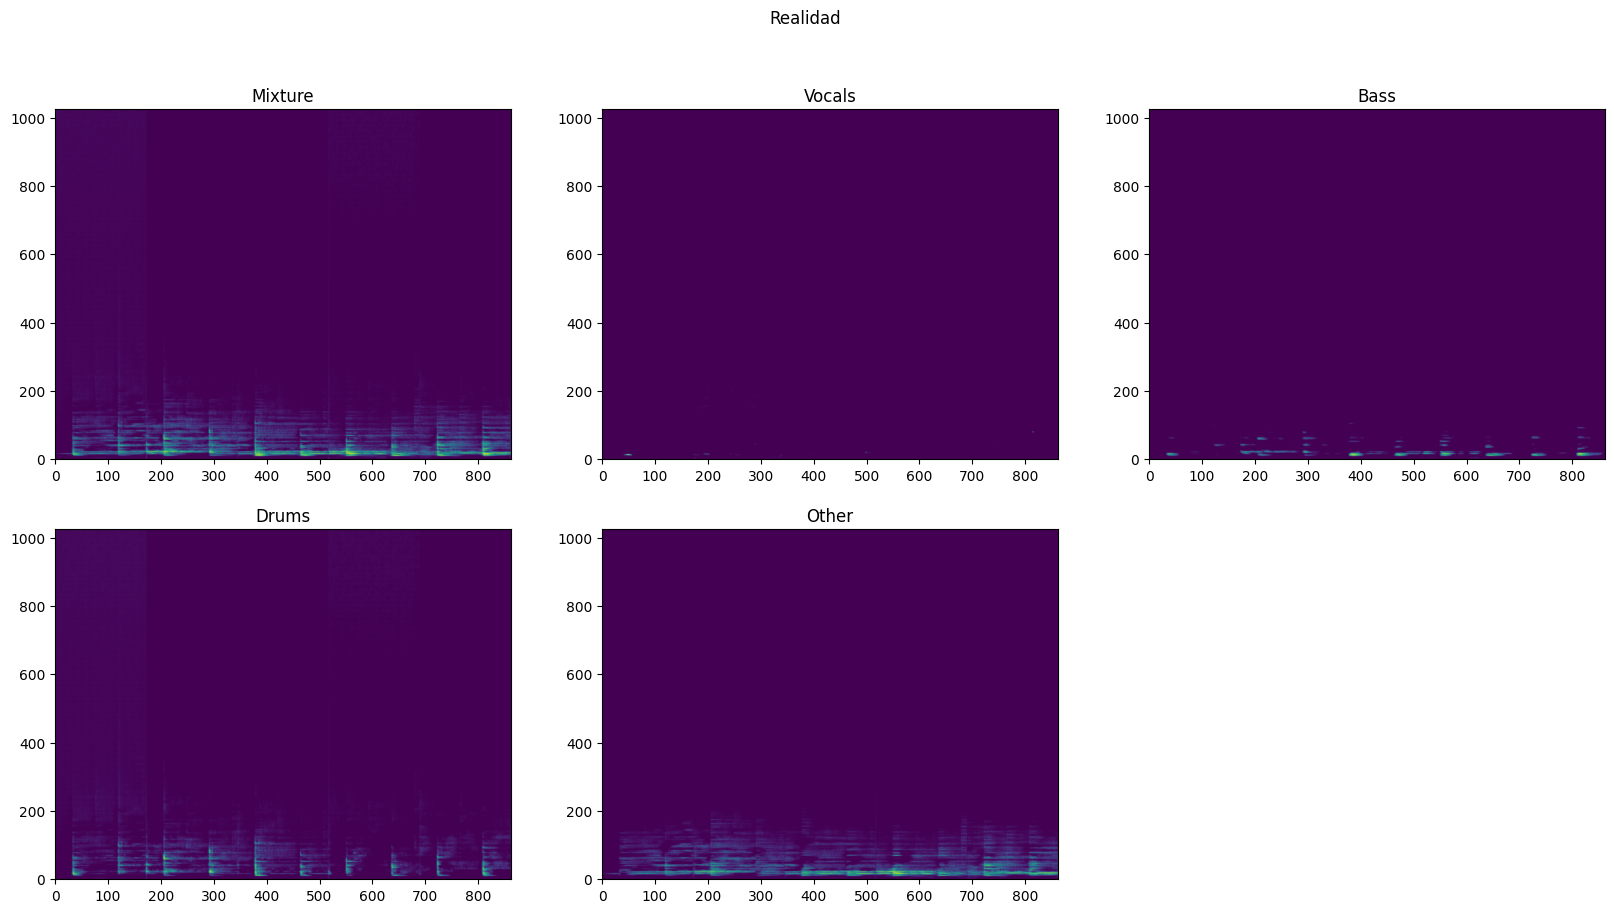

In [26]:
plt.figure(figsize=(20, 10))
plt.suptitle("Realidad")
plt.subplot(2, 3, 1)
plt.title("Mixture")
plt.imshow(
    np.log1p(np.abs(res_bass_stft + res_drums_stft + res_other_stft + res_vocals_stft)),
    aspect="auto",
    origin="lower",
)
plt.subplot(2, 3, 2)
plt.title("Vocals")
plt.imshow(np.log1p(np.abs(res_vocals_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 3)
plt.title("Bass")
plt.imshow(np.log1p(np.abs(res_bass_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 4)
plt.title("Drums")
plt.imshow(np.log1p(np.abs(res_drums_stft)), aspect="auto", origin="lower")
plt.subplot(2, 3, 5)
plt.title("Other")
plt.imshow(np.log1p(np.abs(res_other_stft)), aspect="auto", origin="lower")

In [27]:
torch.save(
    trained_model.state_dict(),
    os.path.join(project_root, "experiments", "checkpoints", f"deep_sampler.pth"),
)
print("Model checkpoint saved.")

Model checkpoint saved.
